In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import root_scalar
# import vegas
# import pandas as pd

In [33]:
# constants
M_sun = 1.9891e30 # solar mass in kg
yr2s = 31556926 # year in seconds
G = 6.67430e-11 # Newton gravity constant, m^3/kg/s^2
mp = 1.6726e-27 # proton mass, kg
kB = 1.38064e-23 # Boltzman constant, m^2 kg /s^2 /K
K2MeV = 1000 / 1.161e13 # Kelvin to MeV
K2erg = 1.3806e-16 # Kelvin to erg
MeV2kg = 1.783e-30 # MeV to kg
light_speed = 29979245800 # cm/s
M_sun_erg = 1.79e54 # solar mass to erg
g2erg = 8.987e20 # 1 gram to erg
cm3_2_perMeV3 = (1/1.973e-11)**3
kB_MeV = 8.617e-11 # MeV/K
me = 0.5 # electron mass MeV

In [35]:
# Load CSM data
# In the following we use realistic CSM density from Zimmerman+ Nature 627, 762 (2024)
rho_SN2020tlf_data = np.log10(np.loadtxt('CSM_density/SN2020tlf.txt').T)
rho_SN2023ixf_data = np.log10(np.loadtxt('CSM_density/SN2023ixf.txt').T)
rho_SN2023ixf_sharp_data = np.log10(np.loadtxt('CSM_density/SN2023ixf_sharp.txt').T)
rho_SN2024ggi_data = np.log10(np.loadtxt('CSM_density/SN2024ggi.txt').T)
# Interp in log10 scale
rho_2020tlf_interp = interp1d(rho_SN2020tlf_data[0],rho_SN2020tlf_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2023ixf_interp = interp1d(rho_SN2023ixf_data[0],rho_SN2023ixf_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2023ixf_s_interp = interp1d(rho_SN2023ixf_sharp_data[0],rho_SN2023ixf_sharp_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2024ggi_interp = interp1d(rho_SN2024ggi_data[0],rho_SN2024ggi_data[1],kind='linear',bounds_error=False,fill_value=np.nan)

# r_max = rho_data[0][-1]
# r_min = rho_data[0][0]

r_mins = {'SN 2020tlf':10**rho_SN2020tlf_data[0,0],'SN 2023ixf':10**rho_SN2023ixf_data[0,0],'SN 2023ixf s':10**rho_SN2023ixf_sharp_data[0,0],'SN 2024ggi':10**rho_SN2024ggi_data[0,0]} 

def CSM_density(r,SN_name='SN 2023ixf'):
    """
    g/cm^3
    """
    r = np.log10(r)
    if SN_name == 'SN 2020tlf':
        return 10**rho_2020tlf_interp(r)
    elif SN_name == 'SN 2023ixf':
        return 10**rho_2023ixf_interp(r)
    elif SN_name == 'SN 2023ixf s':
        return 10**rho_2023ixf_s_interp(r)
    elif SN_name == 'SN 2024ggi':
        return 10**rho_2024ggi_interp(r)
    else:
        raise ValueError('\'SN_name\' must be a \'SN 2020tlf\', \'SN 2023ixf\' or \'SN 2024ggi\'.')

SN_names = ['SN 2020tlf','SN 2023ixf','SN 2024ggi']

Text(0, 0.5, '$\\rho$ [g cm$^{-3}$]')

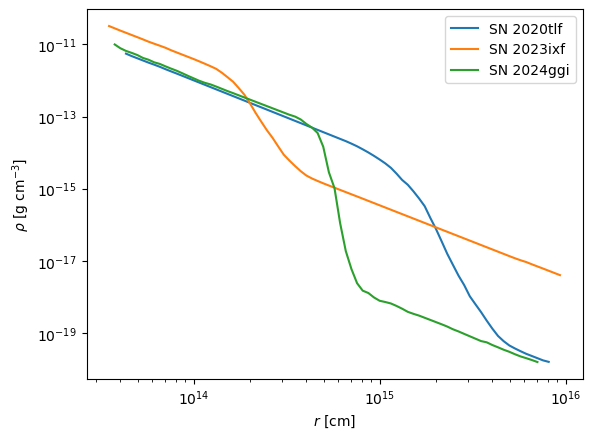

In [15]:
CSM_radii = np.logspace(13,16,100)
for SN_name in SN_names:
    CSM_rho = CSM_density(CSM_radii,SN_name=SN_name)
    plt.plot(CSM_radii,CSM_rho,label=SN_name)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\rho$ [g cm$^{-3}$]')

## CSM initial temperature profile

The model for initial CSM temperature $T_0$ is described by
$$
T_0(r\geq R_*)=T_* \left[\frac{1-\sqrt{1-(R_*/r)^2}}{2}\right]^{1/4}
$$
where $T_*$ and $R_*$ are the temperature and radius of the photospheric sphere. We take $T_* = 2500~{\rm K}$ and $R_*=r_{\rm min}$ the innermost radius of the dense CSM.

In [17]:
def T0_CSM(r,Rs,Ts=2500):
    """
    Initial CSM temperature profile

    In
    ---
    r : scalar
        CSM radius, cm
    Rs : scalar
        The photospheric radius or the innermost radius of the dense CSM, cm
    Ts : scalar
        The photospheric temperature, K
    
    Out
    ---
    out : scalar
        The initial CSM temperature at r, K
    """
    return Ts * ((1 - np.sqrt(1 - (Rs / r)**2)) / 2)**0.25

(13.0, 2300.0)

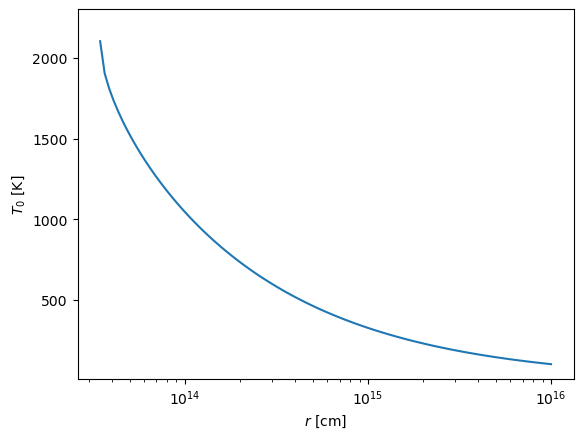

In [8]:
SN_name = 'SN 2023ixf'
Rs = r_mins[SN_name]
CSM_radii = np.logspace(np.log10(Rs),16,100)
CSM_T0 = T0_CSM(CSM_radii,Rs)

plt.plot(CSM_radii,CSM_T0)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$T_0$ [K]')
plt.ylim(13,2300)

## Single-specie gas

### Internal energy density
The internal energy of a gas at temperature $T$ is given by
$$
u(T) = \frac{3}{2}n[1+x(T)]k_BT + nx(T)\chi 
$$
where $n$ is the number density, $x(T)$ the fraction of gas being ionized at $T$ and $\chi$ the ionization energy. Taking hydrogen for example, $\chi=13.6\,{\rm eV}$ and $x$ can be determined by the *Saha equation*
$$
\frac{x^2}{1-x} = \frac{1}{n}\left(\frac{ m_e k_B T}{2\pi \hbar^2}\right)^{3/2}\exp\left(-\frac{\chi}{k_B T}\right)\equiv a(T).
$$
The solution to the Saha equation is
$$
x = \frac{-a+ \sqrt{a(4+a)}}{2}
$$
with the criterion $x\in[0,1]$.

In [11]:
def Saha(T,n,chi):
    """
    Saha equation

    In
    ---
    T : scalar
        Gas temperature, K
    n : scalar
        Gas number density, 1/cm^3
    chi : scalar
        Ionization energy of the gas component, eV

    Out
    ---
    out : scalar
        The ratio of ionized gas, dimensionless
    """
    n = n / cm3_2_perMeV3 # 1/cm^3 to MeV^3
    T = K2MeV * T # convert K to MeV
    chi = chi * 1e-6 # convert chi from eV to MeV
    a = (me * T / 2 / np.pi)**1.5 / n * np.exp(- chi / T)
    x = (- a + np.sqrt(a * (4 + a))) / 2
    return x

def internal_energy_density(T,n,chi):
    """
    The internal energy density of a gas

    In
    ---
    T : scalar
        Gas temperature, K
    n : scalar
        Gas number density, 1/cm^3
    chi : scalar
        Ionization energy of the gas component, eV

    Out
    ---
    out : scalar
        The internal energy density, erg/cm^3
    """
    x = Saha(T,n,chi)
    chi = chi * 1e-6 # convert chi from eV to MeV
    E_th = 1.5 * n * T * K2MeV * (1 + x) # thermal energy
    E_ion = n * x * chi # ionization energy
    u = (E_th + E_ion) * 1.602e-6 # convert MeV/cm^3 to erg/cm^3
    return u

def get_T(x,n,chi,bracket=[1e3,1e5]):
    """
    Get the required T to ionize gas up to a ratio x

    In
    ---
    x : scalar
        The ionization fraction, between (0,1)
    n : scalar
        Gas number density, 1/cm^3
    chi : scalar
        Ionization energy of the gas component, eV
    bracket : list
        The possible range of T, default [1e3,1e5] K

    Out
    ---
    out : scalar
        The temperature, K
    """
    def _f(T):
        return Saha(T,n,chi) - x
    T = root_scalar(_f,method = 'brentq', bracket = bracket).root
    return T

### Setting the constraint

Assuming at temperature $T_{999}$ about $x=0.999$ of the hydrogen will be ionized, this would be sufficient to remove the H I emission line from spectroscopy.
The required energy deposition $\delta Q$ can be estimated by
$$
\delta Q = u(T_{999}) - u(T_0)
$$
where $T_0$ is the original temperature of the CSM. For brevity, we define $u(T_{\rm 999})\equiv u_{999}$ and $u(T_0)\equiv u_0$.

The total energy deposited per layer of CSM is $dQ = \delta Q dV=4\pi r^2 \delta Q dr$ and
suppose the primary component is hydrogen, then $n_{\rm H}=\rho/m_{\rm H}$. We rewrite the above equation as
$$
\frac{dQ}{dr} = 4\pi r^2(u_{999}-u_0).
$$
Given $n$ is a function of CSM density $\rho$, we can deduce the required $dQ/dr$ per CSM layer.

In [15]:
def deltaQ(r,T,n,chi,Rs,Ts=2500):
    """
    Get the required energy density to raise T0 to T, erg/cm^3

    In
    ---
    r : scalar
        The CSM radius, cm
    T : scalar
        The CSM temperature, K
    n : scalar
        Gas number density, 1/cm^3
    chi : scalar
        Ionization energy of the gas component, eV
    Rs : scalar
        The photospheric radius or the innermost radius of the dense CSM, cm
    Ts : scalar
        The photospheric temperature, default 2500 K

    Out
    ---
    out : scalar
        The delta Q, erg/cm^3
    """
    T0 = T0_CSM(r,Rs,Ts)
    u0 = internal_energy_density(T0,n,chi)
    u = internal_energy_density(T,n,chi)
    dQ = u - u0
    return dQ

In [17]:
SN_name = 'SN 2023ixf'
Rs=r_mins[SN_name]
CSM_radii = np.logspace(np.log10(Rs),16,100)
CSM_n = CSM_density(CSM_radii,SN_name=SN_name) / mp / 1000 # convert mp from kg to gram
dQ_T_10000 = deltaQ(CSM_radii,10000,CSM_n,13.6,Rs)

In [250]:
x = 0.9999
T_x_9999 = []
T_x_999999 = []
for n in CSM_n:
    try:
        T_required_9999 = get_T(0.9999,n,13.6,bracket=[1e3,1e5])
        T_required_999999 = get_T(0.999999,n,13.6,bracket=[1e3,1e5])
    except:
        T_required_9999 =get_T(0.9999,n,13.6,bracket=[10,1e4])
        T_required_999999 =get_T(0.999999,n,13.6,bracket=[10,1e4])
    T_x_9999.append(T_required_9999)
    T_x_999999.append(T_required_999999)
T_x_9999 = np.array(T_x_9999)
T_x_999999 = np.array(T_x_999999)
dQ_x_9999 =  deltaQ(CSM_radii,T_x_9999,CSM_n,13.6,Rs)
dQ_x_999999 =  deltaQ(CSM_radii,T_x_999999,CSM_n,13.6,Rs)

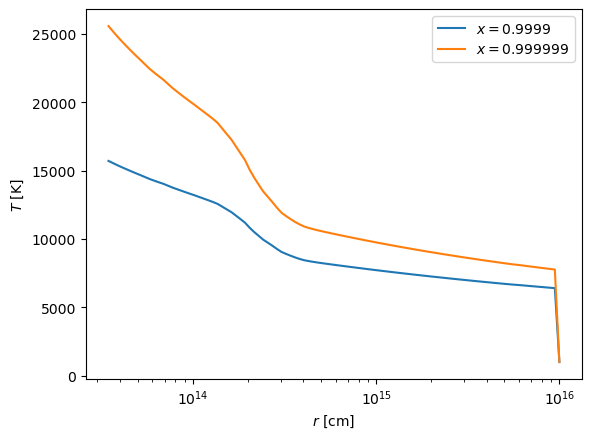

In [254]:
plt.plot(CSM_radii,T_x_9999,label=r'$x=0.9999$')
plt.plot(CSM_radii,T_x_999999,label=r'$x=0.999999$')
#plt.plot(CSM_radii,dQ_x_9999,'--',label=r'$x=0.9999$')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$T$ [K]')
#plt.ylim(13,2300)
plt.legend()
#plt.savefig('required_T_x.png',bbox_inches='tight')

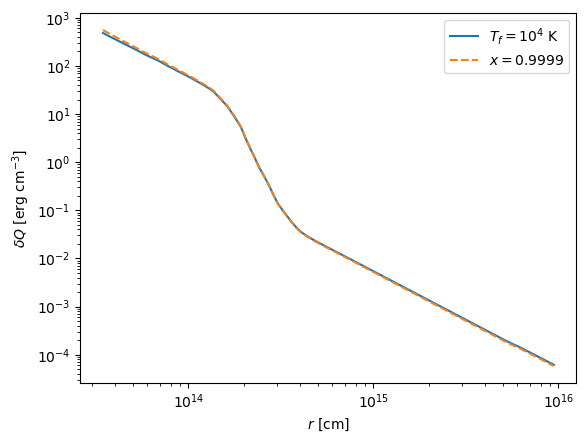

In [256]:
plt.plot(CSM_radii,dQ_T_10000,label=r'$T_f=10^4$ K')
plt.plot(CSM_radii,dQ_x_9999,'--',label=r'$x=0.9999$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\delta Q$ [erg cm$^{-3}$]')
#plt.ylim(13,2300)
plt.legend()

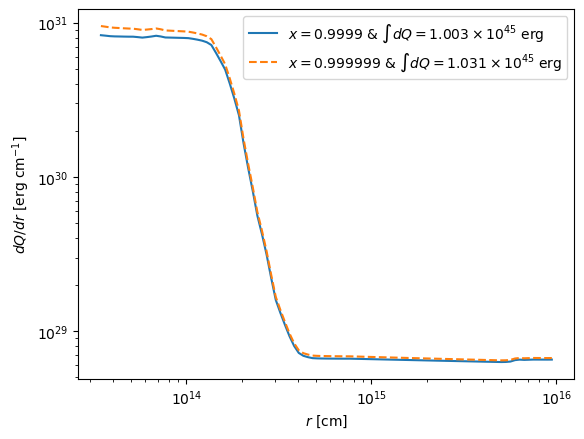

In [258]:
plt.plot(CSM_radii,4*np.pi*CSM_radii**2*dQ_x_9999,label=r'$x=0.9999$ & $\int dQ=1.003\times 10^{45}$ erg')
plt.plot(CSM_radii,4*np.pi*CSM_radii**2*dQ_x_999999,'--',label=r'$x=0.999999$ & $\int dQ=1.031\times 10^{45}$ erg')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$d Q/dr$ [erg cm$^{-1}$]')
#plt.ylim(2.1e28,1.3e31)
plt.legend()
plt.savefig('required_dQdr_x.png',bbox_inches='tight')

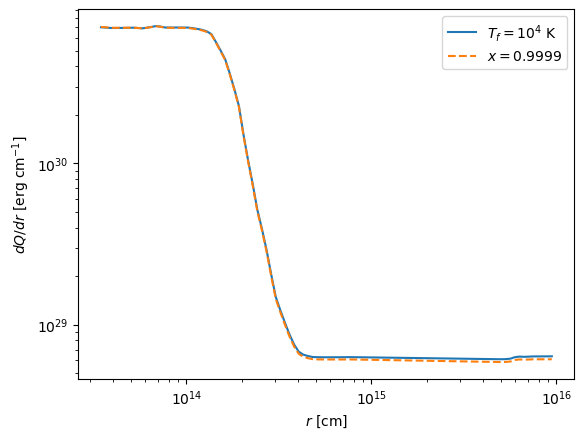

In [19]:
plt.plot(CSM_radii,4*np.pi*CSM_radii**2*dQ_T_10000,label=r'$T_f=10^4$ K')
plt.plot(CSM_radii,4*np.pi*CSM_radii**2*dQ_x_9999,'--',label=r'$x=0.9999$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$d Q/dr$ [erg cm$^{-1}$]')
#plt.ylim(2.1e28,1.3e31)
plt.legend()
plt.savefig('required_dQdr.png',bbox_inches='tight')

In [260]:
log_CSM_radii = np.log10(CSM_radii)
log_dQdr_T_10000 = np.log10(4*np.pi*CSM_radii**2*dQ_T_10000)
log_dQdr_x_9999 = np.log10(4*np.pi*CSM_radii**2*dQ_x_9999)
log_dQdr_x_999999 = np.log10(4*np.pi*CSM_radii**2*dQ_x_999999)

log_dQdr_T_10000_interp = interp1d(log_CSM_radii,log_dQdr_T_10000,bounds_error=False,fill_value=np.nan)
log_dQdr_x_9999_interp = interp1d(log_CSM_radii,log_dQdr_x_9999,bounds_error=False,fill_value=np.nan)
log_dQdr_x_999999_interp = interp1d(log_CSM_radii,log_dQdr_x_999999,bounds_error=False,fill_value=np.nan)

In [262]:
def dQdr_T_10000(r):
    r = np.log10(r)
    return 10**log_dQdr_T_10000_interp(r)

def dQdr_x_9999(r):
    r = np.log10(r)
    return 10**log_dQdr_x_9999_interp(r)

def dQdr_x_999999(r):
    r = np.log10(r)
    return 10**log_dQdr_x_999999_interp(r)

In [264]:
np.log10(quad(dQdr_T_10000,Rs,3e14)[0]),np.log10(quad(dQdr_x_9999,Rs,3e14)[0])

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_35320/52022329.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  np.log10(quad(dQdr_T_10000,Rs,3e14)[0]),np.log10(quad(dQdr_x_9999,Rs,3e14)[0])


(45.036743429786455, 45.06218386384361)

In [266]:
quad(dQdr_x_9999,Rs,3e14)[0],quad(dQdr_x_999999,Rs,3e14)[0]

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_35320/1330343898.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad(dQdr_x_9999,Rs,3e14)[0],quad(dQdr_x_999999,Rs,3e14)[0]


(1.1539416896514475e+45, 1.2708661929721271e+45)

In [274]:
log_Q_th_T_10000 = {'SN 2020tlf':45.30101756394293, 'SN 2023ixf': 46.3995, 'SN 2024ggi':44.96287151865554}
log_Q_th_x_9999 = {'SN 2020tlf':45.29091337917685, 'SN 2023ixf': 46.3995, 'SN 2024ggi':44.95559188582297}

## Constraints

In [37]:
# Load total energy deposition data and taking log10
log_Q_tot_LS220_SN2020tlf = np.log10(np.loadtxt('LS220-s18.88/Q_tot/Q_tot_SN2020tlf.txt'))
log_Q_tot_TF_SN2020tlf = np.log10(np.loadtxt('TF-10.8/Q_tot/Q_tot_SN2020tlf.txt'))
log_Q_tot_SFHo_SN2020tlf = np.log10(np.loadtxt('SFHo-18.8/Q_tot/Q_tot_SN2020tlf.txt'))

log_Q_tot_LS220_SN2023ixf = np.log10(np.loadtxt('LS220-s18.88/Q_tot/Q_tot_SN2023ixf.txt'))
log_Q_tot_TF_SN2023ixf = np.log10(np.loadtxt('TF-10.8/Q_tot/Q_tot_SN2023ixf.txt'))
log_Q_tot_SFHo_SN2023ixf = np.log10(np.loadtxt('SFHo-18.8/Q_tot/Q_tot_SN2023ixf.txt'))

log_Q_tot_LS220_SN2024ggi = np.log10(np.loadtxt('LS220-s18.88/Q_tot/Q_tot_SN2024ggi.txt'))
log_Q_tot_TF_SN2024ggi = np.log10(np.loadtxt('TF-10.8/Q_tot/Q_tot_SN2024ggi.txt'))
log_Q_tot_SFHo_SN2024ggi = np.log10(np.loadtxt('SFHo-18.8/Q_tot/Q_tot_SN2024ggi.txt'))

# Preparing axis values
eps_list = np.logspace(-13.5,-9.8,110)
mAp_axis = np.logspace(0,np.log10(501.1872),91)
eps_axis = eps_list
mAp_mesh,eps_mesh = np.meshgrid(mAp_axis,eps_axis)

# Load SN1987a gamma-ray constraint
sn1987a_gamma_data = np.loadtxt('sn1987a_gamma.txt')

M_CSM_SN2020tlf = 4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name='SN 2020tlf'),r_mins['SN 2020tlf'],5e15,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
M_CSM_SN2023ixf = 4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name='SN 2023ixf'),r_mins['SN 2023ixf'],4e14,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
M_CSM_SN2024ggi = 4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name='SN 2024ggi'),r_mins['SN 2024ggi'],7e14,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg

M_CSMs = {'SN 2020tlf':M_CSM_SN2020tlf,'SN 2023ixf':M_CSM_SN2023ixf,'SN 2024ggi':M_CSM_SN2024ggi} 

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_53621/3701120448.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  M_CSM_SN2020tlf = 4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name='SN 2020tlf'),r_mins['SN 2020tlf'],5e15,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_53621/3701120448.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_35320/1142954340.py:8: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_LS220_SN2020tlf.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_35320/1142954340.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_SFHo_SN2020tlf.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_35320/1142954340.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_TF_SN2020tlf.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_35320/1142954340.py:62: MatplotlibDeprecationWarning: The collections attribute was deprecated in Ma

(3.1e-14, 1.584893192461111e-10)

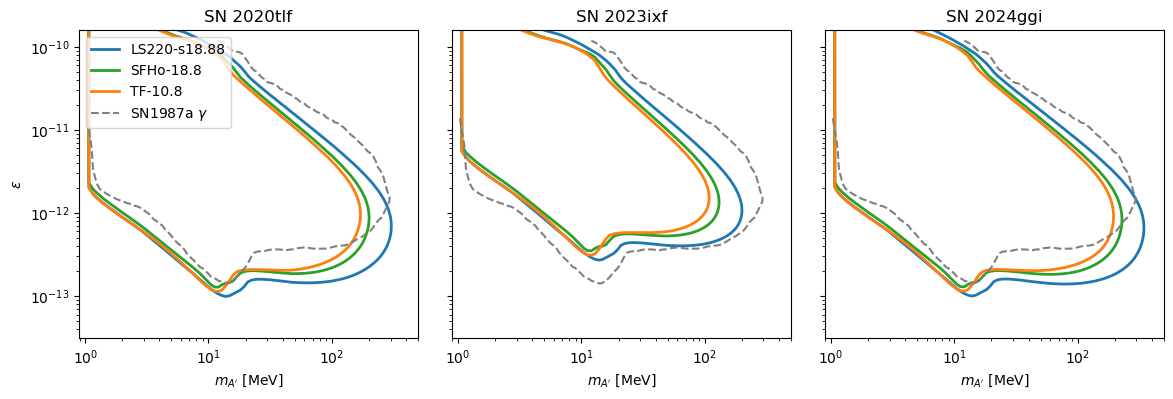

In [278]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

target_contour_LS220_SN2020tlf =  ax1.contour(mAp_mesh, eps_mesh, log_Q_tot_LS220_SN2020tlf, 'r:', levels=[log_Q_th_x_9999['SN 2020tlf']], linewidths=0)
target_contour_TF_SN2020tlf =  ax1.contour(mAp_mesh, eps_mesh, log_Q_tot_TF_SN2020tlf, 'r:', levels=[log_Q_th_x_9999['SN 2020tlf']], linewidths=0)
target_contour_SFHo_SN2020tlf =  ax1.contour(mAp_mesh, eps_mesh, log_Q_tot_SFHo_SN2020tlf, 'r:', levels=[log_Q_th_x_9999['SN 2020tlf']], linewidths=0)

for collection in target_contour_LS220_SN2020tlf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax1.plot(vertices[:, 0], vertices[:, 1],color='C0', linewidth=2, label='LS220-s18.88')

for collection in target_contour_SFHo_SN2020tlf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax1.plot(vertices[:, 0], vertices[:, 1],color='C2', linewidth=2, label='SFHo-18.8')

for collection in target_contour_TF_SN2020tlf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax1.plot(vertices[:, 0], vertices[:, 1],color='C1', linewidth=2, label='TF-10.8')

ax1.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],'--',color='gray',label=r'SN1987a $\gamma$')
ax1.set_title(fr'SN 2020tlf')
legend = ax1.legend(loc='upper left')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$m_{A^\prime}$ [MeV]')
ax1.set_ylabel(r'$\epsilon$')
ax1.set_xlim(0.89,)
ax1.set_ylim(3.1e-14,)


# # 獲取圖例的外框樣式
# legend_bbox = legend.get_frame()
# legend_facecolor = legend_bbox.get_facecolor()  # 背景顏色
# legend_edgecolor = legend_bbox.get_edgecolor()  # 邊框顏色
# legend_boxstyle = legend_bbox.get_boxstyle()    # 邊框樣式


# # 在右上角添加文字，外框樣式與圖例一致
# # 在右上角添加文字，並設置外框和透明背景
# ax1.text(
#     0.05,0.05, fr'$v_w={v_csm:d}$ km s$^{{-1}}$', 
#     transform=ax1.transAxes,
#     fontsize=11,
#     verticalalignment='bottom', horizontalalignment='left',
#     bbox=dict(
#         facecolor=legend_facecolor,  # 背景顏色
#         alpha=0.7,          # 透明度
#         edgecolor=legend_edgecolor,  # 外框顏色
#         boxstyle= 'round,pad=0.4'
#     )
# )



target_contour_LS220_SN2023ixf =  ax2.contour(mAp_mesh, eps_mesh, log_Q_tot_LS220_SN2023ixf, 'r:', levels=[log_Q_th_x_9999['SN 2023ixf']], linewidths=0)
target_contour_TF_SN2023ixf =  ax2.contour(mAp_mesh, eps_mesh, log_Q_tot_TF_SN2023ixf, 'r:', levels=[log_Q_th_x_9999['SN 2023ixf']], linewidths=0)
target_contour_SFHo_SN2023ixf =  ax2.contour(mAp_mesh, eps_mesh, log_Q_tot_SFHo_SN2023ixf, 'r:', levels=[log_Q_th_x_9999['SN 2023ixf']], linewidths=0)

for collection in target_contour_LS220_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax2.plot(vertices[:, 0], vertices[:, 1],color='C0', linewidth=2, label='LS220-s18.88')

for collection in target_contour_SFHo_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax2.plot(vertices[:, 0], vertices[:, 1],color='C2', linewidth=2, label='SFHo-18.8')

for collection in target_contour_TF_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax2.plot(vertices[:, 0], vertices[:, 1],color='C1', linewidth=2, label='TF-10.8')

ax2.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],'--',color='gray',label=r'SN1987a $\gamma$')
ax2.set_title(fr'SN 2023ixf')
#ax2.legend(loc='lower left')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$m_{A^\prime}$ [MeV]')
#ax2.set_ylabel(r'$\epsilon$')
ax2.set_xlim(0.89,)
ax2.set_ylim(3.1e-14,)


target_contour_LS220_SN2024ggi =  ax3.contour(mAp_mesh, eps_mesh, log_Q_tot_LS220_SN2024ggi, 'r:', levels=[log_Q_th_x_9999['SN 2024ggi']], linewidths=0)
target_contour_TF_SN2024ggi =  ax3.contour(mAp_mesh, eps_mesh, log_Q_tot_TF_SN2024ggi, 'r:', levels=[log_Q_th_x_9999['SN 2024ggi']], linewidths=0)
target_contour_SFHo_SN2024ggi =  ax3.contour(mAp_mesh, eps_mesh, log_Q_tot_SFHo_SN2024ggi, 'r:', levels=[log_Q_th_x_9999['SN 2024ggi']], linewidths=0)

for collection in target_contour_LS220_SN2024ggi.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax3.plot(vertices[:, 0], vertices[:, 1],color='C0', linewidth=2, label='LS220-s18.88')

for collection in target_contour_SFHo_SN2024ggi.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax3.plot(vertices[:, 0], vertices[:, 1],color='C2', linewidth=2, label='SFHo-18.8')

for collection in target_contour_TF_SN2024ggi.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax3.plot(vertices[:, 0], vertices[:, 1],color='C1', linewidth=2, label='TF-10.8')

ax3.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],'--',color='gray',label=r'SN1987a $\gamma$')
ax3.set_title(fr'SN 2024ggi')
#ax2.legend(loc='lower left')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$m_{A^\prime}$ [MeV]')
#ax2.set_ylabel(r'$\epsilon$')
ax3.set_xlim(0.89,)
ax3.set_ylim(3.1e-14,)

#plt.savefig('DP_constraint.png',bbox_inches='tight')

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_53621/3913658047.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_LS220_SN2023ixf.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_53621/3913658047.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_SFHo_SN2023ixf.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_53621/3913658047.py:16: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_TF_SN2023ixf.collections:


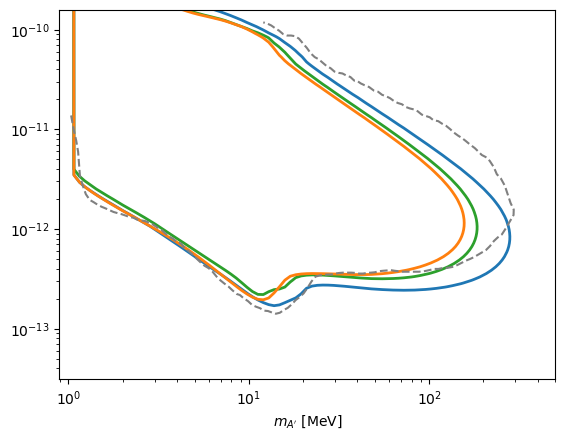

In [53]:
Q_lost_est = np.log10(3.9e45)
target_contour_LS220_SN2023ixf =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_LS220_SN2023ixf, 'r:', levels=[Q_lost_est], linewidths=0)
target_contour_TF_SN2023ixf =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_TF_SN2023ixf, 'r:', levels=[Q_lost_est], linewidths=0)
target_contour_SFHo_SN2023ixf =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_SFHo_SN2023ixf, 'r:', levels=[Q_lost_est], linewidths=0)

for collection in target_contour_LS220_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='C0', linewidth=2, label='LS220-s18.88')

for collection in target_contour_SFHo_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='C2', linewidth=2, label='SFHo-18.8')

for collection in target_contour_TF_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='C1', linewidth=2, label='TF-10.8')

plt.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],'--',color='gray',label=r'SN1987a $\gamma$')
#plt.title(r'$T_{\rm photo}=5000$ K with $\Delta t=4$ hrs')
#ax2.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_{A^\prime}$ [MeV]')
#ax2.set_ylabel(r'$\epsilon$')
plt.xlim(0.89,)
plt.ylim(3.1e-14,)
plt.savefig('DP.png',bbox_inches='tight')

In [25]:
4*np.pi*(1.9*1e14)**2*5.670374*1e-5*10000**4*4*3600

3.70417300637407e+45

## CSM temperature evolution

The heat capacity of constant volume is by definition
$$
C_V =\frac{dU}{dT} = \frac{3}{2}Nk_B(1+x) + N\left(\frac{3}{2}k_B T +\chi\right)\frac{dx}{dT}
$$
where $N$ is the total number of particles and
$$
\frac{dx}{dT}=\frac{x(1-x)}{(2-x)}\left(\frac{3}{2T}+\frac{\chi}{k_B T^2}\right).
$$
Assuming the head conductivity is very efficient and the only cooling comes from the blackbody radiation.
The temperature evolution is governed by
$$
C_V \frac{dT}{dt} = -4\pi \sigma_{\rm SB} R^2 T^4
$$

In [176]:
def dxdT(x,T,n,chi):
    """
    1/K
    """
    n = n / cm3_2_perMeV3 # 1/cm^3 to MeV^3
    T = K2MeV * T # convert K to MeV
    chi = chi * 1e-6 # convert chi from eV to MeV
    #a = (2 * np.pi * me * T)**1.5 / n * np.exp(- chi / T)
    dx = x * (1 - x) * (1.5 / T + chi / T**2) / (2 - x)
    return dx * K2MeV # convert 1/MeV to 1/K

def heat_capacity(T,n,N,chi):
    """
    erg/K
    """
    kB = 1.3806e-16 # erg/K
    eV2erg = 1.6021e-12 # eV to erg
    x = Saha(T,n,chi) 
    dx = dxdT(x,T,n,chi)
    return 1.5 * N * kB * (1 + x) + N * (1.5 * kB * T + chi * eV2erg) * dx # erg/K

def cooling_rate(R,T):
    """
    erg/s
    """
    sb = 5.6704e-5 # erg/cm^2/s/K^4
    return 4 * np.pi * sb * R**2 * T**4

In [311]:
N = 4.287e55
n = 1.602e11
T = 7e3
cooling_rate(1.9e14,T)/heat_capacity(T,n,N,13.6)

0.10581332032627463

In [313]:
heat_capacity(T,n,N,13.6)

5.8369043896507655e+41

In [143]:
dxdT(0.9997,1e4,1e12,13.6)

5.183768805357822e-07

In [160]:
Saha(1e4,1e12,13.6)

0.9969372175384876

In [200]:
0.036*1.989e30/1.67e-27

4.2876646706586815e+55

In [226]:
1.6*1.9

3.04

In [13]:
4*np.pi*(1.9*1e14)**2*5.670374*1e-5*10000**4*4*3600

3.70417300637407e+45